# Temperature index model on individual stakes:
## Setting up:
### Imports:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
import xarray as xr
import warnings
import re
import seaborn as sns

warnings.filterwarnings("ignore")

from scripts.xgb_helpers import *
from scripts.stakes_processing import *
from scripts.xgb_input import *
from scripts.xgb_model import *
from scripts.plots_clean import *
from scripts.xgb_metrics import *
from scripts.PDD_model_modules import *
from scripts.PDD_model_calibration import *
from scripts.PDD_helpers import *

%load_ext autoreload
%autoreload 2

### Constants:

In [2]:
# set seed
seed_all(SEED)

# Kfold is because we don't want the model to be evaluated on a lucky fold, so we do
# 5x train and test model on different folds and report average metrics
KFOLD = True
if KFOLD:
    NUM_FOLDS = 5
else:
    NUM_FOLDS = 1

# INPUT_TYPE = "MeteoSuisse"  # Options: "MeteoSuisse" "ERA5-Land""
INPUT_TYPE = "ERA5-Land"
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

print('Seed:', SEED)

Seed: 5


## Pre-processing:

In [3]:
# Get number of stakes per glacier and their names
glStakesNum, glStakes = get_StakesNum(path_GLAMOS_csv)
glStakes_sorted = sorted(glStakesNum.items(), key=lambda x: x[1])

# Get total number of stakes
num_stakes = 0
for (glacier, num) in (glStakes_sorted):
    num_stakes += num
print('Total number of stakes (before processing):', num_stakes)
print('Number of stakes per glacier:\n', glStakes_sorted)

# glacier names:
glaciers = list(glStakes.keys())
# Keep only the glaciers with more than 20 years of measurements
glStakes_20years, glStakes_20years_sorted, glStakes_20years_all = getStakesNyears(
    glaciers,
    glStakes,
    path_glacattr,
    path_era5_stakes,
    input_type="MeteoSuisse",
    N=20)
glaciers = list(glStakes_20years.keys())

print('After preprocessing:---\nNumber of glaciers:',
      len(glStakes_20years.keys()))
num_stakes = 0
for gl in glStakes_20years.keys():
    num_stakes += len(glStakes_20years[gl])
print('Number of stakes:', num_stakes)

Total number of stakes (before processing): 46
Number of stakes per glacier:
 [('sanktanna', 1), ('adler', 1), ('schwarzberg', 1), ('plainemorte', 1), ('allalin', 1), ('hohlaub', 1), ('corbassiere', 1), ('tsanfleuron', 2), ('gries', 2), ('pizol', 2), ('clariden', 2), ('pers', 2), ('murtel', 2), ('plattalva', 2), ('basodino', 3), ('rhone', 3), ('limmern', 3), ('silvretta', 3), ('gietro', 3), ('findelen', 4), ('aletsch', 6)]
1991 2023
1991 2023
1991 2023
2011 2023
2004 2023
2004 2023
2004 2023
2004 2023
2005 2023
2009 2023
2009 2023
1961 2023
1961 2023
2006 2023
2006 2023
2006 2023
1955 2023
Missing years: [2016, 2017, 2018, 2019, 2020]
1920 2023
1995 2023
1920 2023
1920 2023
1920 2023
1920 2023
1948 1984
1948 1984
1948 1984
2006 2021
2006 2021
2009 2023
1914 2023
1914 2023
1955 2023
1914 2023
1914 2023
1914 2023
1955 2023
2001 2023
2001 2023
2012 2023
2012 2023
1996 2023
1948 1984
1948 1984
1966 2023
1966 2023
1966 2023
After preprocessing:---
Number of glaciers: 13
Number of stakes: 28

### Get surface height of climate variables and stakes:
In the temperature index model, we need to use the height of stakes to interpolate era5 variables to stake height.

Can get geopotential from ERA5-Land [website](https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation?preview=/140385202/188026704/geo_1279l4_0.1x0.1.grib2_v4_unpack.nc#ERA5Land:datadocumentation-parameterlistingParameterlistings). 
The geopotential height is the geopotential divided by the WMO-defined gravity constant of 9.80665 m/s**2. 

Text(0.5, 1.0, 'Elevation of stake and closest ERA5-Land grid cell')

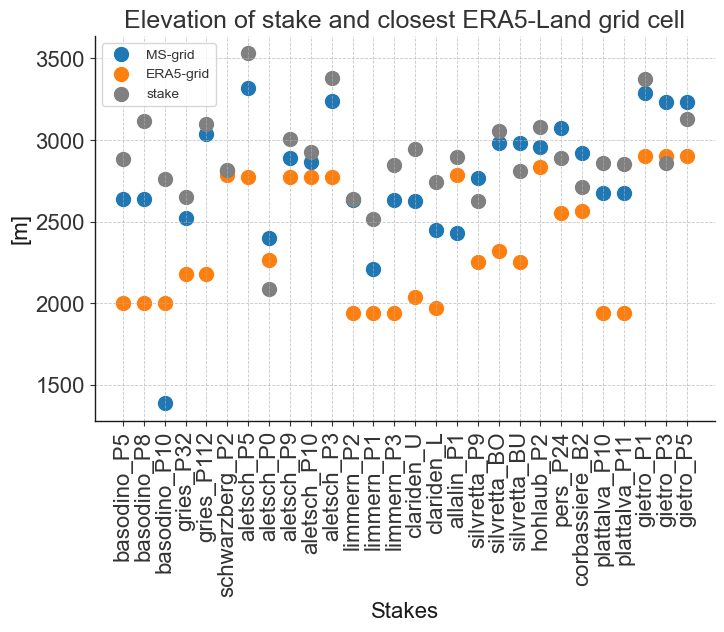

In [4]:
stake_grid_alt, stake_alt = getSurfaceHeight(glStakes_20years.keys(),
                                             glStakes_20years,
                                             input_type="MeteoSuisse")

stake_grid_alt_era5, stake_alt_era5 = getSurfaceHeight(glStakes_20years.keys(),
                                             glStakes_20years,
                                             input_type="ERA5-Land")

# PLOT
figure = plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
ax.scatter(stake_grid_alt.keys(),
           stake_grid_alt.values(),
           label=f'MS-grid')
ax.scatter(stake_grid_alt_era5.keys(),
           stake_grid_alt_era5.values(),
           label=f'ERA5-grid')
ax.scatter(stake_alt.keys(), stake_alt.values(), label='stake', color = 'grey')
ax.legend()
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel('[m]')
ax.set_xlabel('Stakes')
ax.set_title(f'Elevation of stake and closest {INPUT_TYPE} grid cell')

### Get temperature gradients between pressure levels:

Get temperature gradient dT/dz per meter to calculate the temperature at stakes. For this, get the temperature between pressure levels from ERA5 (didn't find any plevels for ERA5 Land, see 1.0.3 PDD_model_download_ERA5_hourly).

In [5]:
dTdz_stakes = getTemperatureGradients(glStakes_20years.keys(),
                                      glStakes_20years,
                                      path_ERA5=path_ERA5,
                                      path_glacattr=path_glacattr)

glaciers:   0%|          | 0/13 [00:00<?, ?it/s]

-0.568 degrees per 100m


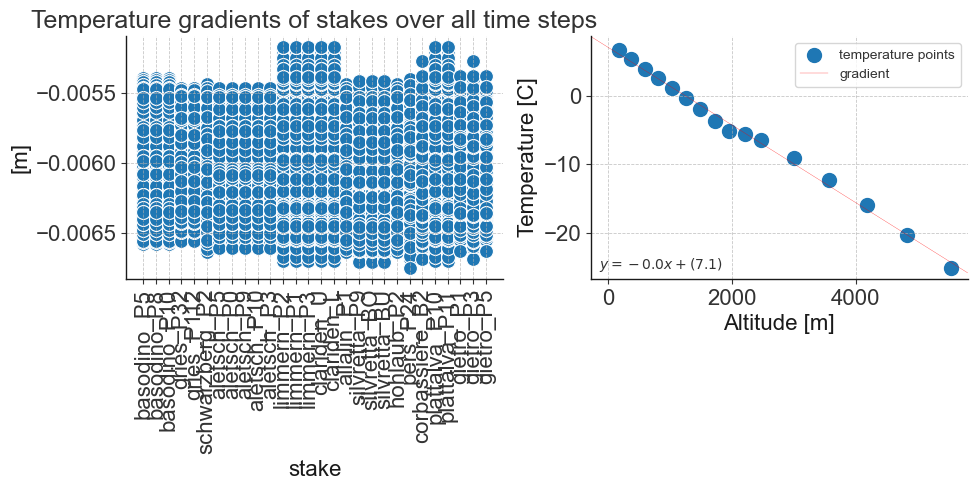

In [6]:
# Plot temperature gradients:
alldTdz, allstakes = [], []
for stake in dTdz_stakes.keys():
    alldTdz.append(dTdz_stakes[stake].dTdz)
    allstakes.append(np.tile(stake, len(dTdz_stakes[stake].dTdz)))

allDf = pd.DataFrame({
    'stake': np.concatenate(allstakes),
    'dTdz': np.concatenate(alldTdz)
})

# Example of one stake and how temperature gradient is calculated:
fileName = re.split('.csv', 'clariden_U_mb.csv')[0]
stakeName = re.split('_', fileName)[0] + '_' + re.split('_', fileName)[1]
stake = 'clariden_U_mb.csv'
plevelsFile = path_ERA5 + 'era5-monthly-t2m-geopot-plevels.nc'
xr_plevels = xr.open_dataset(plevelsFile)

# Get coordinates and time of file for this stake:
df_stake = read_stake_csv(path_glacattr, stake)
slope = dTdz_stakes[stakeName].iloc[0].dTdz
intercept = dTdz_stakes[stakeName].iloc[0].intercept
pt = (0, intercept)

xr_plevels_stake = xr_plevels.sel(latitude=df_stake.lat.unique(),
                                  longitude=df_stake.lon.unique(),
                                  method="nearest").isel(longitude=0,
                                                         latitude=0,
                                                         expver=0)
plvel_alt = xr_plevels_stake.isel(time=0).z.to_dataframe().reset_index()[[
    'level', 'z'
]]

t_plevels = xr_plevels_stake.isel(time=0).to_dataframe().reset_index()[[
    'level', 'z', 't'
]]
t_plevels['alt'] = t_plevels['z'] / (9.80665)  # Change to [m] from [m^2 s-2]
t_plevels['temp'] = t_plevels['t'] - 273.15  # Change from K to C

figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
sns.scatterplot(allDf, x='stake', y='dTdz')
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel('[m]')
ax.set_title('Temperature gradients of stakes over all time steps')

ax = plt.subplot(1, 2, 2)
ax.scatter(x=t_plevels['alt'], y=t_plevels['temp'], label='temperature points')
ax.axline(pt,
          slope=slope,
          color="red",
          linestyle="-",
          linewidth=0.2,
          label='gradient')
legend_text = "\n".join((r"$y = %.1fx +(%.1f)$" % (
    slope,
    intercept,
), ))
print('{} degrees per 100m'.format(round(slope * 100, 3)))
ax.text(0.02,
        0.02,
        legend_text,
        transform=ax.transAxes,
        verticalalignment="bottom")
ax.set_ylabel('Temperature [C]')
ax.set_xlabel('Altitude [m]')
ax.legend()

plt.tight_layout()

## Example of one stake and one year:

### Correction for sub-monthly temperature variability:

Show an example of correction for submonthly temperature variability for one stake and one year. 

FileNotFoundError: [Errno 2] No such file or directory: '/scratch-3/vmarijn/data/MB_modeling/ERA5/ERA5Land-stakes/clariden_U_mb_full.nc'

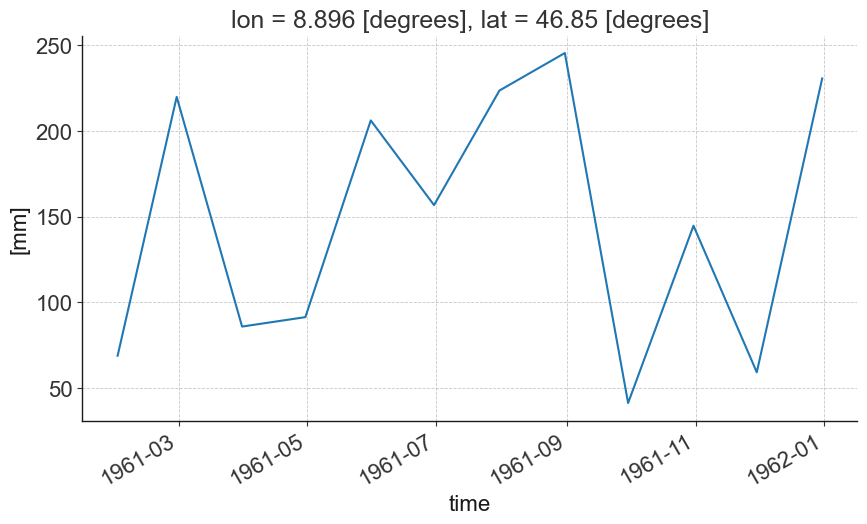

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
xr_full = xr.open_dataset(path_MS + f"{fileName}_full.nc").sortby("time")
(xr_full.sel(time='1961')['tp']).plot(ax=ax, label='MS')
ax.set_ylabel('[mm]')

xr_full = xr.open_dataset(path_era5_stakes +
                          f"{fileName}_full.nc").sortby("time")
(xr_full.sel(time='1961')['tp']).plot(ax=ax, label='ERA5')
ax.legend()

In [9]:
stake = 'clariden_U_mb.csv'
stakeName = re.split('_', stake)[0] + '_' + re.split('_', stake)[1]
fileName = re.split(".csv", stake)[0]

el_stake = stake_alt[stakeName]
el_grid = stake_grid_alt[stakeName]
long_vars = {'t2m': 'temperature', 'tp': 'total_prec'}

# temperature and total precipitation on stake grid for one year:
year = 1995
yearly_range = pd.date_range(str(year) + "-10-01",
                             str(year + 1) + "-10-01",
                             freq="1M")
monthly_range = range(0, 12, 1)

if INPUT_TYPE == "MeteoSuisse":
    # monthly Meteo Suisse data
    xr_full = xr.open_dataset(path_MS + f"{fileName}_full.nc").sortby("time")
    yearDF = (xr_full[long_vars.keys()].sel(
        time=yearly_range).to_dataframe().reset_index().drop(["lat", "lon"],
                                                             axis=1))
    t_era5 = yearDF['t2m'].values  # [C]
    p_era5 = yearDF['tp'].values / (1000)  # [m]

if INPUT_TYPE == "ERA5-Land":
    xr_full = xr.open_dataset(path_era5_stakes +
                              f"{fileName}_full.nc").sortby("time")
    yearDF = (xr_full[long_vars.keys()].sel(
        time=yearly_range).to_dataframe().reset_index().drop(
            ["expver", "latitude", "longitude"], axis=1))
    t_era5 = yearDF['t2m'].values  # [C]
    p_era5 = yearDF['tp'].values / (1000)  # [m]

# Constants:
dTdz = dTdz_stakes['clariden_U']
dTdz['time'] = pd.to_datetime(dTdz['time'])
dTdz = dTdz.set_index('time')  # dtdz = -6.5 / (1000)  # set constant for now
dpdz = 1 / 10000  # % increase/100m constant for now changed to unit/m

# Initial values
SUR_0, SNOW_0, BAL_0 = 0, 0, 0
c_prec = 1.5
tg_clariden, tg_clariden_pdd = [], []

pc_m, pg_m, psg_m = [], [], []
for i in tqdm(monthly_range):
    month_name = list(INVERSE_MONTH_VAL.keys())[i]
    monthNb = INVERSE_MONTH_VAL[month_name]

    dtdz = dTdz.loc[str(year)].iloc[i - 1].dTdz

    tg = getTempGl(stake,
                   t_era5,
                   dtdz,
                   el_stake,
                   el_grid,
                   year,
                   i,
                   input_type=INPUT_TYPE)
    tg_clariden.append(tg)

    # Get PDD
    tg_clariden_pdd.append(
        get_PDD(tg, year, i, stake, input_type=INPUT_TYPE))

    # Get precipitation:
    pc, pg, psg = getPrecGl(c_prec,
                            p_era5,
                            dpdz,
                            el_stake,
                            el_grid,
                            tg,
                            i,
                            T_thresh=1.5)

    pc_m.append(pc)
    pg_m.append(pg)
    psg_m.append(psg)

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1)
ax.plot(list(MONTH_VAL.values()),
        tg_clariden,
        label=f'Stake t2m aggr from {INPUT_TYPE}')
ax.plot(list(MONTH_VAL.values()), tg_clariden_pdd, label='Stake t2m PDD')
ax.plot(list(MONTH_VAL.values()), t_era5, label=f'{INPUT_TYPE} monthly t2m')

ax.set_title(f'Temperature [{INPUT_TYPE}]')
ax.set_ylabel('[deg C]')
ax.legend()
ax.tick_params(axis="x", rotation=90)
ax = plt.subplot(1, 2, 2)
ax.plot(list(MONTH_VAL.values()), p_era5, label=f'{INPUT_TYPE} prec')
ax.plot(list(MONTH_VAL.values()), pc_m, label=f'{INPUT_TYPE} prec scaled')
ax.plot(list(MONTH_VAL.values()), pg_m, label='Stake prec')
ax.plot(list(MONTH_VAL.values()), psg_m, label='Stake solid prec')
ax.tick_params(axis="x", rotation=90)
ax.set_title(f'Precipitation [{INPUT_TYPE}]')
ax.set_ylabel('[m]')
ax.legend()
plt.suptitle('Clariden U')
plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch-3/vmarijn/data/MB_modeling/ERA5/ERA5Land-stakes/clariden_U_mb_full.nc'

In [10]:
# Show examples of PDD for individual months:
fig = plt.figure(figsize=(10, 8))
for i in monthly_range:
    tg = getTempGl(stake,
                   t_era5,
                   dtdz,
                   el_stake,
                   el_grid,
                   year,
                   i,
                   input_type=INPUT_TYPE)
    month_name = list(INVERSE_MONTH_VAL.keys())[i]
    monthNb = INVERSE_MONTH_VAL[month_name]

    # get daily temperature from hourly era5-land data
    ax = plt.subplot(3, 4, i + 1)
    dailytemp_grid, daily_std, daily_mean = getDailyTemp(year,
                                                         i,
                                                         stake,
                                                         el_stake,
                                                         el_grid,
                                                         dtdz,
                                                         input_type=INPUT_TYPE)

    if INPUT_TYPE == 'ERA5-Land':
        daily_temps_corrdf = dailytemp_grid.t2m.to_dataframe().drop(
            ['latitude', 'longitude'], axis=1)
        y = 't2m'
    elif INPUT_TYPE == 'MeteoSuisse':
        daily_temps_corrdf = dailytemp_grid.TabsD.to_dataframe().drop(
            ['lat', 'lon'], axis=1)
        y = 'TabsD'

    sns.lineplot(daily_temps_corrdf, x='time', y=y, ax=ax)
    ax.set_title(f'Month: {monthNb}')
    ax.axhline(y=tg, color='orange', label=f'{INPUT_TYPE} monthly mean')
    tg_pdd = get_PDD(tg,
                     year,
                     i,
                     stake,
                     input_type=INPUT_TYPE)

    ax.axhline(y=tg_pdd, color='green', label='PDD monthly mean')
    ax.set_ylim(top=8)
    ax.tick_params(axis="x", rotation=90)
    if i == 12:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

NameError: name 't_era5' is not defined

<Figure size 1000x800 with 0 Axes>

## Calibration of PDD:

In [11]:
# PARAMETERS:
# D_SNOW = 0.2
# D_ICE = 0.97
# D_WATER = 1

# Initial values
SUR_0, SNOW_0, BAL_0 = 0, 0, 0  # start as ice
dPdz = 1 / 10000  # % increase/100m constant for now changed to unit/m

c_prec = 1.5  # []
DDFsnow, DDFice = 3 / 1000, 6 / 1000  # constant [m d-1 K-1]

inital_params = {
    'sur0': SUR_0,
    'sno0': SNOW_0,
    'bal0': BAL_0,
}

# CALIBRATION:
# Range of parameters to fit during round 1 (cprec) and round 2 (DDFsnow)
DDFsnow_range = np.linspace(1 / (1000), 10 / (1000), 25)
c_prec_range = np.linspace(0.8, 4, 25)

#### Pre-run MeteoSuisse: 
Create arrays needed to run the PDD model later (makes things faster).

In [12]:
RUN = False
path_MS_daily = '../../data/MB_modeling/MeteoSuisse/TabsD_verified/lonlat/'
if RUN:
    # Get surface height of stakes and era5/MS grid:
    stake_grid_alt, stake_alt = getSurfaceHeight(glStakes_20years.keys(),
                                                 glStakes_20years,
                                                 input_type='MeteoSuisse')
    dTdz_stakes = getTemperatureGradients(glStakes_20years.keys(),
                                          glStakes_20years)
    create_prerun_MS(glStakes_20years, path_MS_daily, stake_grid_alt,
                     stake_alt, dTdz_stakes)

#### Pre-run ERA5-Land: 
PDD needs hourly grid resampled to monthly for one part. Compute that first:

In [13]:
RUN = False
if RUN:
    # Get surface height of stakes and era5/MS grid:
    stake_grid_alt, stake_alt = getSurfaceHeight(glStakes_20years.keys(),
                                                 glStakes_20years,
                                                 input_type='ERA5-Land')
    dTdz_stakes = getTemperatureGradients(glStakes_20years.keys(),
                                          glStakes_20years)
    create_prerun_ERA5Land(glStakes_20years, stake_grid_alt, stake_alt, dTdz_stakes)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch-3/vmarijn/data/MB_modeling/ERA5/ERA5Land-stakes/clariden_U_mb_full.nc'

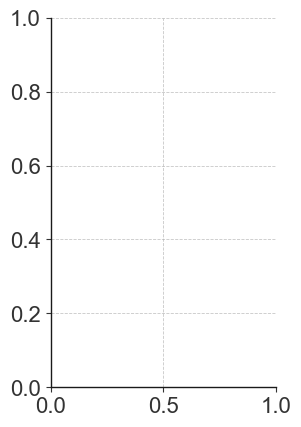

In [14]:
ax = plt.subplot(1, 2, 1)
xr_full = xr.open_dataset(path_era5_stakes +
                          f"clariden_U_mb_full.nc").sortby("time")
plt.plot(xr_full.sel(time=pd.date_range("1961-10-01", "1962-10-01", freq="1M"),
                     method='nearest').t2m.to_numpy(),
         label='era5')

era5_test = pd.read_csv(
    '../../data/MB_modeling/ERA5/ERA5-Land-tg/clariden_U.csv')
era5_test[era5_test.year == 1961].tg.plot(label='era5-scaled')
ax.legend()

ax = plt.subplot(1, 2, 2, sharey = ax)
xr_full = xr.open_dataset(path_MS +
                          f"clariden_U_mb_full.nc").sortby("time")
plt.plot(xr_full.sel(time=pd.date_range("1961-10-01", "1962-10-01", freq="1M"),
                     method='nearest').t2m.to_numpy(),
         label='MS')

MS_test = pd.read_csv(
    '../../data/MB_modeling/MeteoSuisse/MeteoSuisse-tg/clariden_U.csv')
MS_test[MS_test.year == 1961].tg.plot(label='MS-scaled')

ax.legend()
plt.tight_layout()

### Match winter and annual MB:

Fits winter MB during round 1 by modifying `cprec` and annual MB during round 2 by modifying `DDFsnow`.

#### Meteo Suisse:

Running for input type: MeteoSuisse
Remaining stakes:
 {}
[1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019 2020 2021]


<Axes: xlabel='time'>

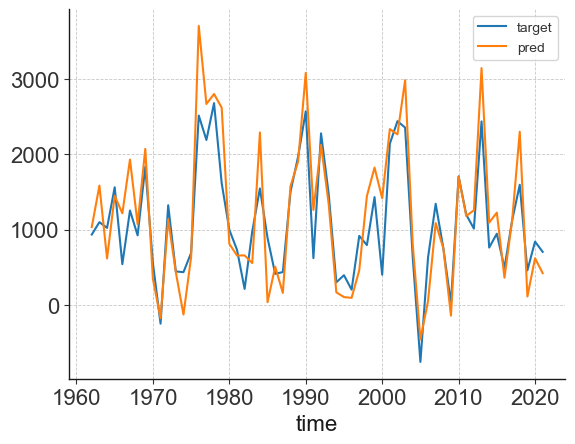

In [15]:
INPUT_TYPE = 'MeteoSuisse'
empty = False
path = f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual_winter/{SEED}/'
if empty:
    emptyfolder(
      path  
    )

RUN = False
createPath(path)
rem_stakes = findStakesNotProc(
    glStakes_20years,
    path=
    path)
print('Running for input type:', INPUT_TYPE)
print('Remaining stakes:\n', rem_stakes)
if RUN:
    if len(rem_stakes.keys()) != 0:
        runPDD_model(
            #glStakes_20years,
            rem_stakes,
            #{'clariden':['clariden_U_mb.csv']},
            dPdz,
            c_prec,
            DDFsnow,
            DDFice,
            DDFsnow_range,
            c_prec_range,
            inital_params,
            match_winter=True,
            kfold=KFOLD,
            log=True,
            empty_path=False,
            input_type=INPUT_TYPE)

# test:
with open(
        f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual_winter/{SEED}/var_clariden_U.pkl',
        "rb") as fp:
    var_pdd_a = pickle.load(fp)
time_pdd = var_pdd_a['feat_test']['time']
time_pdd.sort()
print(time_pdd)
# Test:
df = pd.DataFrame({
    'time': var_pdd_a['feat_test']['time'],
    'target': var_pdd_a['feat_test']['target_a'],
    'pred': var_pdd_a['annual_pred_PDD']
})
df.plot(x='time', y=['target', 'pred'])

#### ERA5-Land:

In [ ]:
glaciers = list(glStakes_20years.keys())

# Get surface height of stakes and era5/MS grid:
stake_grid_alt, stake_alt = getSurfaceHeight(glaciers,
                                             glStakes_20years,
                                             input_type="ERA5-Land")

# Get temperature gradients:
print('Constructing temperature gradients from ERA5:')
dTdz_stakes = getTemperatureGradients(glaciers, glStakes_20years)

In [ ]:
INPUT_TYPE = 'ERA5-Land'
empty = False
if empty:
    emptyfolder(
        f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual_winter/'
    )

RUN = False
rem_stakes = findStakesNotProc(
    glStakes_20years,
    path=
    f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual_winter/')
print('Running for input type:', INPUT_TYPE)
print('Remaining stakes:\n')
print(rem_stakes)
if RUN:
    if len(rem_stakes.keys()) != 0:
        runPDD_model(
            #glStakes_20years,
            rem_stakes,
            #{'clariden':['clariden_U_mb.csv']},
            dPdz,
            c_prec,
            DDFsnow,
            DDFice,
            DDFsnow_range,
            c_prec_range,
            inital_params,
            match_winter=True,
            kfold=KFOLD,
            log=True,
            empty_path=False,
            input_type=INPUT_TYPE)
# test:
with open(
        f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual_winter/var_clariden_U.pkl',
        "rb") as fp:
    var_pdd_a = pickle.load(fp)
time_pdd = var_pdd_a['feat_test']['time']
time_pdd.sort()
print(time_pdd)
# Test:
df = pd.DataFrame({
    'time': var_pdd_a['feat_test']['time'],
    'target': var_pdd_a['feat_test']['target_a'],
    'pred': var_pdd_a['annual_pred_PDD']
})
df.plot(x='time', y=['target', 'pred'])

### Match only annual MB:

Fix cprec and vary only DDFsnow.

#### Meteo Suisse:

In [ ]:
empty = False
if empty:
    emptyfolder(
        f'../../data/MB_modeling/PDD/kfold/MeteoSuisse/match_annual/')

RUN = False
rem_stakes = findStakesNotProc(
    glStakes_20years,
    path=f'../../data/MB_modeling/PDD/kfold/MeteoSuisse/match_annual/')
print('Running for input type:', "MeteoSuisse")
print('Remaining stakes:\n', rem_stakes)
if RUN:
    if len(rem_stakes.keys()) != 0:
        runPDD_model(
            #glStakes_20years,
            rem_stakes,
            #{'clariden':['clariden_U_mb.csv']},
            dPdz,
            c_prec,
            DDFsnow,
            DDFice,
            DDFsnow_range,
            c_prec_range,
            inital_params,
            match_winter=False,
            kfold=KFOLD,
            log=True,
            empty_path=False,
            input_type="MeteoSuisse")
# test:
with open(
        f'../../data/MB_modeling/PDD/kfold/MeteoSuisse/match_annual/var_clariden_U.pkl',
        "rb") as fp:
    var_pdd_a = pickle.load(fp)
time_pdd = var_pdd_a['feat_test']['time']
time_pdd.sort()
print(time_pdd)
# Test:
df = pd.DataFrame({
    'time': var_pdd_a['feat_test']['time'],
    'target': var_pdd_a['feat_test']['target_a'],
    'pred': var_pdd_a['annual_pred_PDD']
})
df.plot(x='time', y=['target', 'pred'])

#### ERA5-Land:

In [ ]:
INPUT_TYPE = 'ERA5-Land'
empty = False
if empty:
    emptyfolder(
        f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual/')

RUN = False
rem_stakes = findStakesNotProc(
    glStakes_20years,
    path=f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/match_annual/')
print('Running for input type:', INPUT_TYPE)
print('Remaining stakes:\n', rem_stakes)
if RUN:
    if len(rem_stakes.keys()) != 0:
        runPDD_model(
            #glStakes_20years,
            rem_stakes,
            #{'clariden':['clariden_U_mb.csv']},
            dPdz,
            c_prec,
            DDFsnow,
            DDFice,
            DDFsnow_range,
            c_prec_range,
            inital_params,
            match_winter=False,
            kfold=KFOLD,
            log=True,
            empty_path=False,
            input_type=INPUT_TYPE)

# test:
with open(
        f'../../data/MB_modeling/PDD/kfold/ERA5-Land/match_annual/var_silvretta_P9.pkl',
        "rb") as fp:
    var_pdd_a = pickle.load(fp)
time_pdd = var_pdd_a['feat_test']['time']
time_pdd.sort()
print(time_pdd)
# Test:
df = pd.DataFrame({
    'time': var_pdd_a['feat_test']['time'],
    'target': var_pdd_a['feat_test']['target_a'],
    'pred': var_pdd_a['annual_pred_PDD']
})
df.plot(x='time', y=['target', 'pred'])

### Other calibration: 

Random grid search of parameters that give the lowest annual MAE: 

In [ ]:
# PARAMETERS:
# D_SNOW = 0.2
# D_ICE = 0.97
# D_WATER = 1

# Initial values
SUR_0, SNOW_0, BAL_0 = 0, 0, 0  # start as ice
dPdz = 1 / 10000  # % increase/100m constant for now changed to unit/m

c_prec = 1.5  # []
DDFsnow, DDFice = 3 / 1000, 6 / 1000  # constant [m d-1 K-1]

inital_params = {
    'sur0': SUR_0,
    'sno0': SNOW_0,
    'bal0': BAL_0,
}

# CALIBRATION:
# Range of parameters to fit during round 1 (cprec) and round 2 (DDFsnow)
DDFsnow_range = np.linspace(1 / (1000), 10 / (1000), 25)
c_prec_range = np.linspace(0.8, 4, 25)

INPUT_TYPE = 'MeteoSuisse'

In [ ]:
param_grid = list(itertools.product(DDFsnow_range, c_prec_range))
len(param_grid)

In [ ]:
n_iter = 50
random_grid = sample(param_grid, n_iter)
dfparam = pd.DataFrame(param_grid, columns=['DDFsnow', 'c_prec'])
dfparam_random = pd.DataFrame(random_grid, columns=['DDFsnow', 'c_prec'])

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(2, 2, 1)
sns.histplot(data=dfparam, x='DDFsnow', kde = True)

ax = plt.subplot(2, 2, 2)
sns.histplot(data=dfparam_random, x='DDFsnow', kde = True)

ax = plt.subplot(2, 2, 3)
sns.histplot(data=dfparam, x='c_prec', kde = True)

ax = plt.subplot(2, 2, 4)
sns.histplot(data=dfparam_random, x='c_prec', kde = True)

plt.tight_layout()

In [ ]:
empty = False
if empty:
    emptyfolder(
        f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/calib_2.0/match_annual_winter/')

RUN = False
rem_stakes = findStakesNotProc(
    glStakes_20years,
    path=f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/calib_2.0/match_annual_winter/')
print('Running for input type:', "MeteoSuisse")
print('Remaining stakes:\n', rem_stakes)

if RUN:
    runPDD_model(
            rem_stakes,
            dPdz,
            c_prec,
            DDFsnow,
            DDFice,
            DDFsnow_range,
            c_prec_range,
            inital_params,
            match_winter=True,
            kfold=KFOLD,
            log=True,
            empty_path=False,
            input_type=INPUT_TYPE,
            calib_style= 2)

# test:
with open(
        f'../../data/MB_modeling/PDD/kfold/{INPUT_TYPE}/calib_2.0/match_annual_winter/var_clariden_U.pkl',
        "rb") as fp:
    var_pdd_a = pickle.load(fp)
time_pdd = var_pdd_a['feat_test']['time']
time_pdd.sort()
print(time_pdd)
# Test:
df = pd.DataFrame({
    'time': var_pdd_a['feat_test']['time'],
    'target': var_pdd_a['feat_test']['target_a'],
    'pred': var_pdd_a['annual_pred_PDD']
})
df.plot(x='time', y=['target', 'pred'])